**Code of Starlight team:Tomiris,Yussuf,Kulash**

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

import sys
sys.path.insert(0,'/content/drive/MyDrive/')
print("In drive folder")

Mounted at /content/drive/
In drive folder


In [3]:
cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [2]:
!pip install  mne==0.18

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 22.8 MB/s 
  Created wheel for mne: filename=mne-0.18.0-py3-none-any.whl size=6313879 sha256=6b5a1c9b06fbdbf556d98f3747058d0fb34c24ee2fb2fdef9ae5b785e1417559
  Stored in directory: /root/.cache/pip/wheels/bb/24/ca/d448d47c51c3fb4f4d467993238870505444aa4b7508640dee
Successfully built mne


import libraries

In [4]:
import os
import argparse
from tqdm.notebook import tqdm
import gc
import shutil 
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from joblib import Parallel, delayed

import numpy as np
from numpy import genfromtxt

from keras import backend as K

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense,BatchNormalization, Dropout, Input
from tensorflow.keras.layers import LSTM, Dense,BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import random
import torch.nn.functional as F

from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal import butter, lfilter, convolve, boxcar

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import utils
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import mne
from mne.channels import read_montage
from mne.io import RawArray
from mne import create_info, find_events, Epochs, concatenate_raws, pick_types
from mne.epochs import concatenate_epochs

Convert csv to mne format
Define the classes for the getting raw data

In [5]:
def creat_mne_raw_object(fname, read_events=True):
    """Create a mne raw instance from csv file."""
    # Read EEG file
    data = pd.read_csv(fname)

    # get chanel names
    ch_names = list(data.columns[1:])

    # read EEG standard montage from mne
    montage = read_montage('standard_1005', ch_names)

    ch_type = ['eeg']*len(ch_names)
    data = 1e-6*np.array(data[ch_names]).T

    if read_events:
        # events file
        ev_fname = fname.replace('_data', '_events')
        # read event file
        events = pd.read_csv(ev_fname)
        events_names = events.columns[1:]
        events_data = np.array(events[events_names]).T

        # define channel type, the first is EEG, the last 6 are stimulations
        ch_type.extend(['stim']*6)
        ch_names.extend(events_names)
        # concatenate event file and data
        data = np.concatenate((data, events_data))

    # create and populate MNE info structure
    info = create_info(ch_names, sfreq=500.0, ch_types=ch_type,
                       montage=montage)
    info['filename'] = fname

    # create raw object
    raw = RawArray(data, info, verbose=False)

    return raw

def get_raw(subject):
    fnames =  glob('subj%d_series*_data.csv' % (subject))
    fnames.sort()
    raw = concatenate_raws([creat_mne_raw_object(fname) for fname in fnames])
    picks = pick_types(raw.info, eeg=True)
    return raw, picks
    
datas = []

Filtering with ICA to remove eye blink

/usr/local/lib/python3.7/dist-packages/mne/io/meas_info.py:1903: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ch_types = np.atleast_1d(np.array(ch_types, np.str))
<ipython-input-6-a65d0e470cad>:31: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  montage=montage)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and g

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks


<ipython-input-7-be7051768451>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-7-be7051768451>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-7-be7051768451>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-7-be7051768451>:4: RuntimeWarning: the "filename" key is misleading and info

Selection by number: 32 components


<ipython-input-7-be7051768451>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-7-be7051768451>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-7-be7051768451>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-7-be7051768451>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-7-be7051768451>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the

Fitting ICA took 66.1s.


<ipython-input-7-be7051768451>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-7-be7051768451>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-7-be7051768451>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


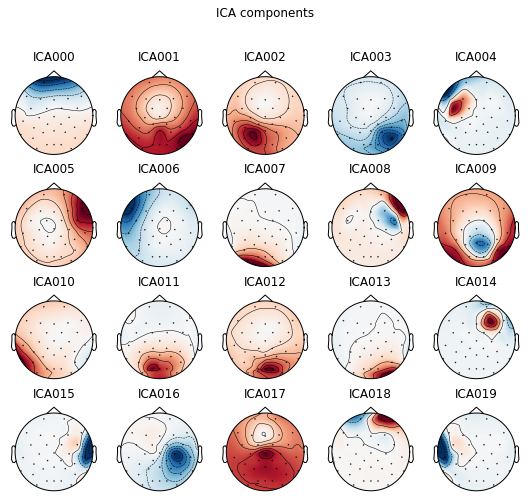

<ipython-input-7-be7051768451>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-7-be7051768451>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


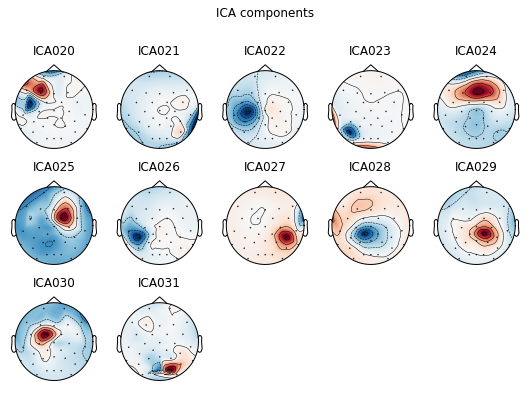

[<Figure size 540x504 with 20 Axes>, <Figure size 540x396 with 15 Axes>]

In [ ]:
data, picks = get_raw(1) #subject 1

ica = mne.preprocessing.ICA(n_components=32, random_state=0)
ica.fit(data.copy().filter(7,30))
ica.plot_components(sensors=True) 

In [ ]:
ica.exclude = [0,18,20]
data1 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
datas.append(data1)

<ipython-input-8-ce46cc18e021>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data1 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-8-ce46cc18e021>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data1 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by it

Transforming to ICA space (32 components)
Zeroing out 3 ICA components


<ipython-input-8-ce46cc18e021>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data1 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-8-ce46cc18e021>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data1 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-8-ce46cc18e021>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data1 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-8-ce46cc18e021>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data1 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-8-ce46cc18e021>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data1 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias

/usr/local/lib/python3.7/dist-packages/mne/io/meas_info.py:1903: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ch_types = np.atleast_1d(np.array(ch_types, np.str))
<ipython-input-4-a65d0e470cad>:31: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  montage=montage)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and g

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks


<ipython-input-7-89bccbf98763>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-7-89bccbf98763>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-7-89bccbf98763>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-7-89bccbf98763>:4: RuntimeWarning: the "filename" key is misleading and info

Selection by number: 32 components


<ipython-input-7-89bccbf98763>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-7-89bccbf98763>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-7-89bccbf98763>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-7-89bccbf98763>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-7-89bccbf98763>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the

Fitting ICA took 109.5s.


<ipython-input-7-89bccbf98763>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-7-89bccbf98763>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-7-89bccbf98763>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


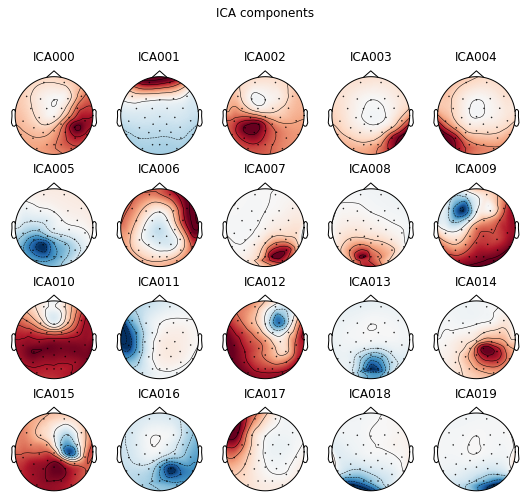

<ipython-input-7-89bccbf98763>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-7-89bccbf98763>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


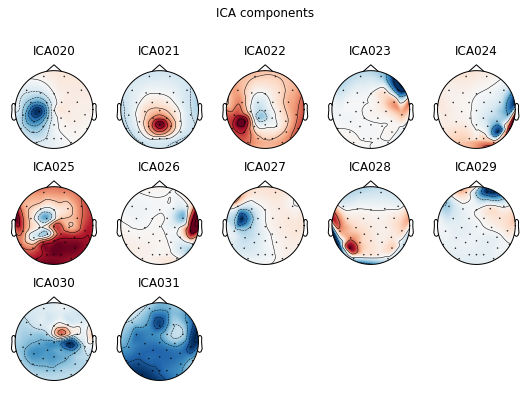

[<Figure size 540x504 with 20 Axes>, <Figure size 540x396 with 15 Axes>]

In [ ]:
data, picks = get_raw(2) #subject 2

ica = mne.preprocessing.ICA(n_components=32, random_state=0)
ica.fit(data.copy().filter(7,30))
ica.plot_components(sensors=True) 

In [ ]:
ica.exclude = [1, 27,29]
data2 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
datas.append(data2)

<ipython-input-8-b7d2404351ea>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data2 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-8-b7d2404351ea>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data2 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by it

Transforming to ICA space (32 components)
Zeroing out 3 ICA components


<ipython-input-8-b7d2404351ea>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data2 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-8-b7d2404351ea>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data2 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-8-b7d2404351ea>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data2 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-8-b7d2404351ea>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data2 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-8-b7d2404351ea>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data2 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias

/usr/local/lib/python3.7/dist-packages/mne/io/meas_info.py:1903: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ch_types = np.atleast_1d(np.array(ch_types, np.str))
<ipython-input-5-a65d0e470cad>:31: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  montage=montage)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and g

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks


/usr/local/lib/python3.7/dist-packages/mne/filter.py:183: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  N * (np.log2(N) + 1))
<ipython-input-28-5987d98875a0>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

Selection by number: 32 components


<ipython-input-28-5987d98875a0>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-28-5987d98875a0>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-28-5987d98875a0>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-28-5987d98875a0>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-28-5987d98875a0>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wante

Fitting ICA took 81.6s.


<ipython-input-28-5987d98875a0>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-28-5987d98875a0>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-28-5987d98875a0>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


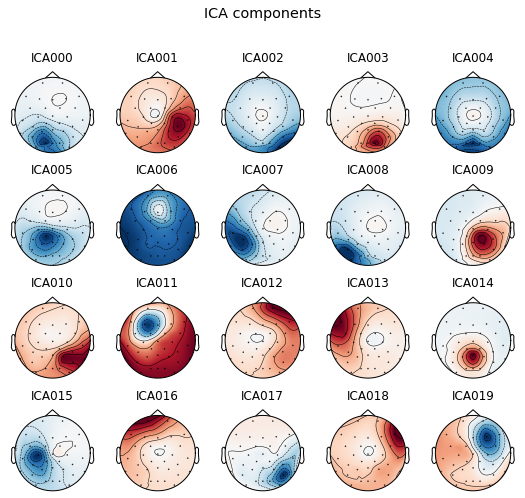

<ipython-input-28-5987d98875a0>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-28-5987d98875a0>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


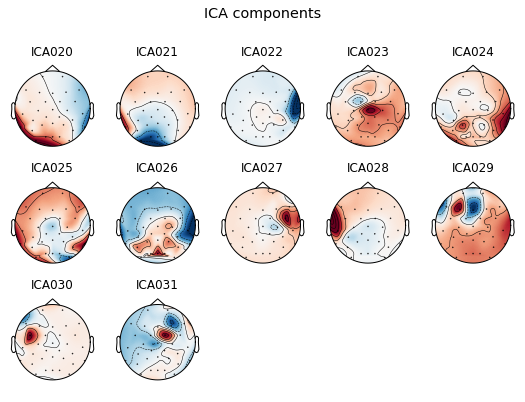

[<Figure size 540x504 with 20 Axes>, <Figure size 540x396 with 15 Axes>]

In [28]:
data, picks = get_raw(3) #subject 3

ica = mne.preprocessing.ICA(n_components=32, random_state=0)
ica.fit(data.copy().filter(7,30))
ica.plot_components(sensors=True) 

In [ ]:
ica.exclude = [12,16,30]
data3 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
datas.append(data3)

<ipython-input-10-2c03a3c8bb8a>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data3 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-10-2c03a3c8bb8a>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data3 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by 

Transforming to ICA space (32 components)
Zeroing out 3 ICA components


/usr/local/lib/python3.7/dist-packages/mne/io/meas_info.py:1903: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ch_types = np.atleast_1d(np.array(ch_types, np.str))
<ipython-input-5-a65d0e470cad>:31: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  montage=montage)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and g

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks


<ipython-input-6-99e868ffe52e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-6-99e868ffe52e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-6-99e868ffe52e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-6-99e868ffe52e>:4: RuntimeWarning: the "filename" key is misleading and info

Selection by number: 32 components


<ipython-input-6-99e868ffe52e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-6-99e868ffe52e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-6-99e868ffe52e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-6-99e868ffe52e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-6-99e868ffe52e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the

Fitting ICA took 62.3s.


<ipython-input-6-99e868ffe52e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-6-99e868ffe52e>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-6-99e868ffe52e>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


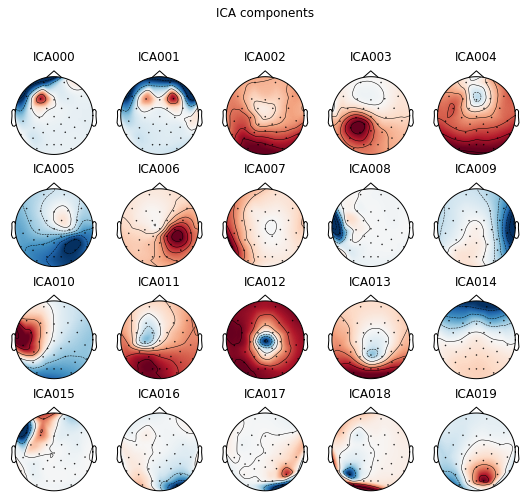

<ipython-input-6-99e868ffe52e>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-6-99e868ffe52e>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


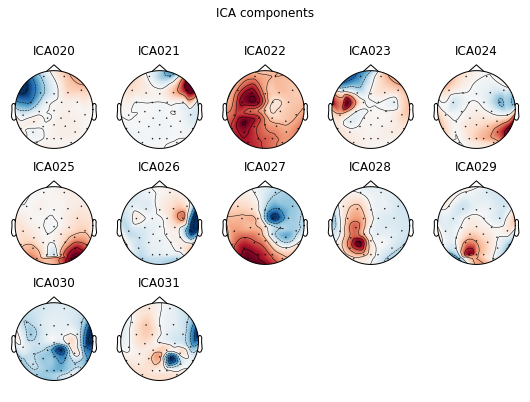

[<Figure size 540x504 with 20 Axes>, <Figure size 540x396 with 15 Axes>]

In [6]:
data, picks = get_raw(4) #subject 4

ica = mne.preprocessing.ICA(n_components=32, random_state=0)
ica.fit(data.copy().filter(7,30))
ica.plot_components(sensors=True) 

In [7]:
ica.exclude = [0,1,14,15,21,20]
data4 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
datas.append(data4)

<ipython-input-7-fbaf51411587>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data4 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-7-fbaf51411587>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data4 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by it

Transforming to ICA space (32 components)
Zeroing out 6 ICA components


<ipython-input-7-fbaf51411587>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data4 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-7-fbaf51411587>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data4 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-7-fbaf51411587>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data4 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-7-fbaf51411587>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data4 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-7-fbaf51411587>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data4 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias

/usr/local/lib/python3.7/dist-packages/mne/io/meas_info.py:1903: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ch_types = np.atleast_1d(np.array(ch_types, np.str))
<ipython-input-4-a65d0e470cad>:31: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  montage=montage)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and g

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks


<ipython-input-13-abf69dbb2c6b>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-13-abf69dbb2c6b>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-13-abf69dbb2c6b>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-13-abf69dbb2c6b>:4: RuntimeWarning: the "filename" key is misleading and 

Selection by number: 32 components


<ipython-input-13-abf69dbb2c6b>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-13-abf69dbb2c6b>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-13-abf69dbb2c6b>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-13-abf69dbb2c6b>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-13-abf69dbb2c6b>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wante

Fitting ICA took 94.3s.


<ipython-input-13-abf69dbb2c6b>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-13-abf69dbb2c6b>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-13-abf69dbb2c6b>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


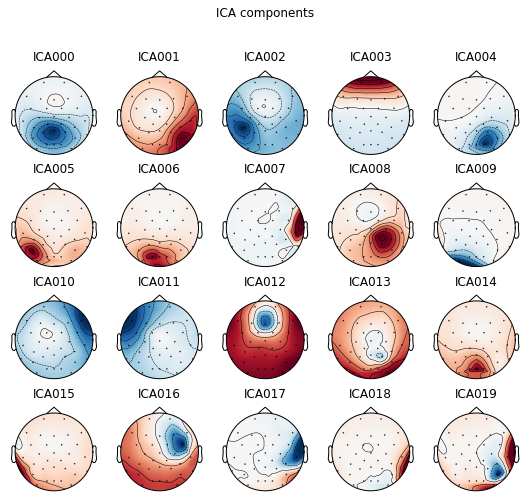

<ipython-input-13-abf69dbb2c6b>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-13-abf69dbb2c6b>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


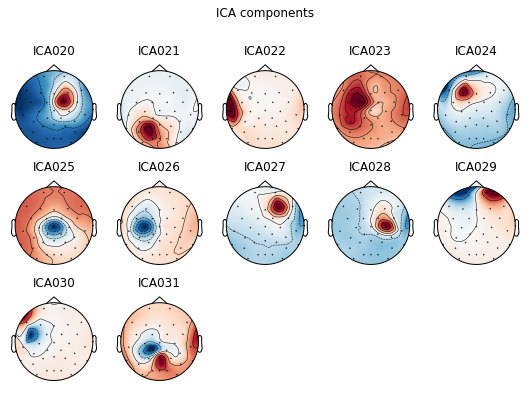

[<Figure size 540x504 with 20 Axes>, <Figure size 540x396 with 15 Axes>]

In [ ]:
data, picks = get_raw(5) #subject 5

ica = mne.preprocessing.ICA(n_components=32, random_state=0)
ica.fit(data.copy().filter(7,30))
ica.plot_components(sensors=True) 

In [ ]:
ica.exclude = [3, 24,29,10,11]
data5 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
datas.append(data5)

<ipython-input-14-77f68ae1a815>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data5 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-14-77f68ae1a815>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data5 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by 

Transforming to ICA space (32 components)
Zeroing out 5 ICA components


<ipython-input-14-77f68ae1a815>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data5 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-14-77f68ae1a815>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data5 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-14-77f68ae1a815>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data5 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-14-77f68ae1a815>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data5 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-14-77f68ae1a815>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data5 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated 

/usr/local/lib/python3.7/dist-packages/mne/io/meas_info.py:1903: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ch_types = np.atleast_1d(np.array(ch_types, np.str))
<ipython-input-4-a65d0e470cad>:31: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  montage=montage)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and g

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks


<ipython-input-15-72eb00756605>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-15-72eb00756605>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-15-72eb00756605>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-15-72eb00756605>:4: RuntimeWarning: the "filename" key is misleading and 

Selection by number: 32 components


<ipython-input-15-72eb00756605>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-15-72eb00756605>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-15-72eb00756605>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-15-72eb00756605>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-15-72eb00756605>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wante

Fitting ICA took 121.5s.


<ipython-input-15-72eb00756605>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-15-72eb00756605>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-15-72eb00756605>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


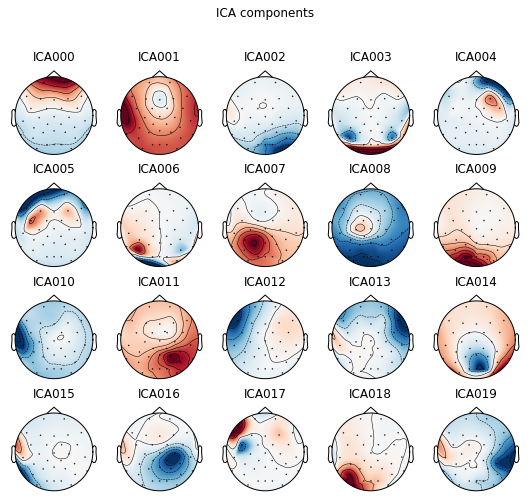

<ipython-input-15-72eb00756605>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-15-72eb00756605>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


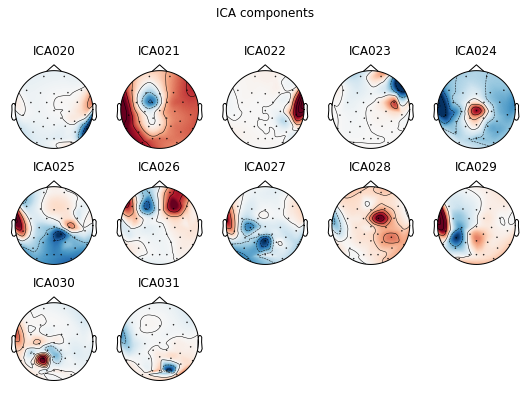

[<Figure size 540x504 with 20 Axes>, <Figure size 540x396 with 15 Axes>]

In [ ]:
data, picks = get_raw(6) #subject 6

ica = mne.preprocessing.ICA(n_components=32, random_state=0)
ica.fit(data.copy().filter(7,30))
ica.plot_components(sensors=True) 

In [ ]:
ica.exclude = [26,23,0,4,12,13]
data6 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
datas.append(data6)

<ipython-input-16-7b655802a3fa>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data6 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-16-7b655802a3fa>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data6 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by 

Transforming to ICA space (32 components)
Zeroing out 6 ICA components


<ipython-input-16-7b655802a3fa>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data6 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-16-7b655802a3fa>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data6 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-16-7b655802a3fa>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data6 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-16-7b655802a3fa>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data6 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-16-7b655802a3fa>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data6 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated 

/usr/local/lib/python3.7/dist-packages/mne/io/meas_info.py:1903: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ch_types = np.atleast_1d(np.array(ch_types, np.str))
<ipython-input-4-a65d0e470cad>:31: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  montage=montage)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and g

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks


/usr/local/lib/python3.7/dist-packages/mne/filter.py:183: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  N * (np.log2(N) + 1))
<ipython-input-17-91b509613a6c>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

Selection by number: 32 components


<ipython-input-17-91b509613a6c>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-17-91b509613a6c>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-17-91b509613a6c>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-17-91b509613a6c>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-17-91b509613a6c>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wante

Fitting ICA took 67.8s.


<ipython-input-17-91b509613a6c>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-17-91b509613a6c>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-17-91b509613a6c>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


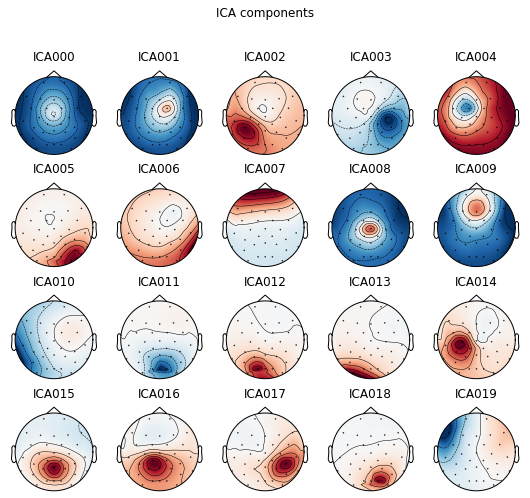

<ipython-input-17-91b509613a6c>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-17-91b509613a6c>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


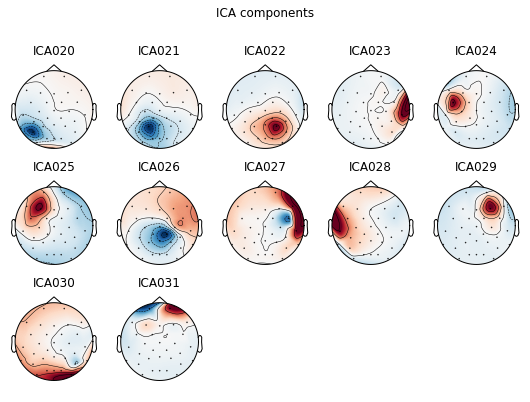

[<Figure size 540x504 with 20 Axes>, <Figure size 540x396 with 15 Axes>]

In [ ]:
data, picks = get_raw(7) #subject 7

ica = mne.preprocessing.ICA(n_components=32, random_state=0)
ica.fit(data.copy().filter(7,30))
ica.plot_components(sensors=True) 

In [ ]:
ica.exclude = [7, 19, 31]
data7 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
datas.append(data7)

<ipython-input-18-d954c08e8e7a>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data7 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-18-d954c08e8e7a>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data7 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by 

Transforming to ICA space (32 components)
Zeroing out 3 ICA components


/usr/local/lib/python3.7/dist-packages/mne/io/meas_info.py:1903: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ch_types = np.atleast_1d(np.array(ch_types, np.str))
<ipython-input-4-a65d0e470cad>:31: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  montage=montage)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and g

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks


<ipython-input-19-821202c0c40e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-19-821202c0c40e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-19-821202c0c40e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-19-821202c0c40e>:4: RuntimeWarning: the "filename" key is misleading and 

Selection by number: 32 components


<ipython-input-19-821202c0c40e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-19-821202c0c40e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-19-821202c0c40e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-19-821202c0c40e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-19-821202c0c40e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wante

Fitting ICA took 98.6s.


<ipython-input-19-821202c0c40e>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-19-821202c0c40e>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-19-821202c0c40e>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


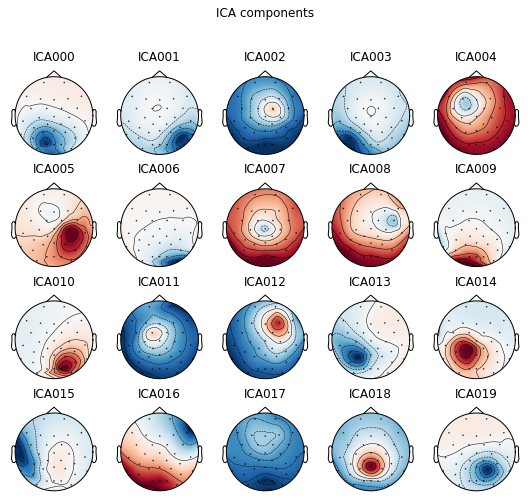

<ipython-input-19-821202c0c40e>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-19-821202c0c40e>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


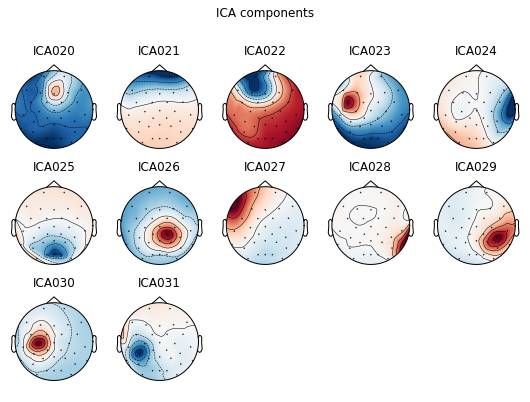

[<Figure size 540x504 with 20 Axes>, <Figure size 540x396 with 15 Axes>]

In [ ]:
data, picks = get_raw(8) #subject 8

ica = mne.preprocessing.ICA(n_components=32, random_state=0)
ica.fit(data.copy().filter(7,30))
ica.plot_components(sensors=True) 

In [ ]:
ica.exclude = [ 27, 21]
data8 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
datas.append(data8)

<ipython-input-20-f17b7de4ca8c>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data8 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-20-f17b7de4ca8c>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data8 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by 

Transforming to ICA space (32 components)
Zeroing out 2 ICA components


<ipython-input-20-f17b7de4ca8c>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data8 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-20-f17b7de4ca8c>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data8 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-20-f17b7de4ca8c>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data8 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-20-f17b7de4ca8c>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data8 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-20-f17b7de4ca8c>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data8 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated 

/usr/local/lib/python3.7/dist-packages/mne/io/meas_info.py:1903: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ch_types = np.atleast_1d(np.array(ch_types, np.str))
<ipython-input-5-a65d0e470cad>:31: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  montage=montage)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and g

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks


/usr/local/lib/python3.7/dist-packages/mne/filter.py:183: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  N * (np.log2(N) + 1))
<ipython-input-24-3c46c5e959e7>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

Selection by number: 32 components


<ipython-input-24-3c46c5e959e7>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-24-3c46c5e959e7>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-24-3c46c5e959e7>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-24-3c46c5e959e7>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-24-3c46c5e959e7>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wante

Fitting ICA took 69.3s.


<ipython-input-24-3c46c5e959e7>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-24-3c46c5e959e7>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-24-3c46c5e959e7>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


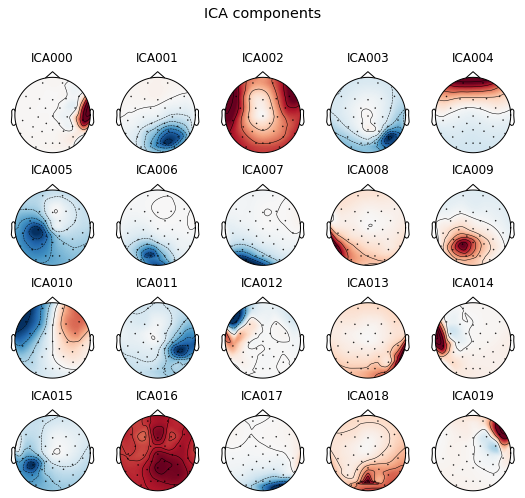

<ipython-input-24-3c46c5e959e7>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-24-3c46c5e959e7>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


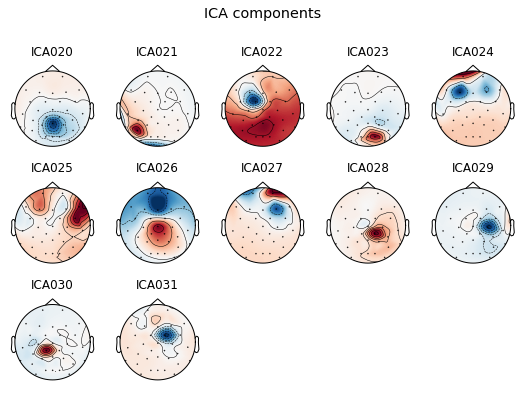

[<Figure size 540x504 with 20 Axes>, <Figure size 540x396 with 15 Axes>]

In [24]:
data, picks = get_raw(9) #subject 9

ica = mne.preprocessing.ICA(n_components=32, random_state=0)
ica.fit(data.copy().filter(7,30))
ica.plot_components(sensors=True) 

In [25]:
ica.exclude = [4, 12,19,24, 27]
data9 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
datas.append(data9)

<ipython-input-25-8ae7808528dc>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data9 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-25-8ae7808528dc>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data9 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by 

Transforming to ICA space (32 components)
Zeroing out 5 ICA components


/usr/local/lib/python3.7/dist-packages/mne/io/meas_info.py:1903: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ch_types = np.atleast_1d(np.array(ch_types, np.str))
<ipython-input-4-a65d0e470cad>:31: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  montage=montage)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and g

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks


<ipython-input-23-e420c1fa1855>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-23-e420c1fa1855>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-23-e420c1fa1855>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-23-e420c1fa1855>:4: RuntimeWarning: the "filename" key is misleading and 

Selection by number: 32 components


<ipython-input-23-e420c1fa1855>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-23-e420c1fa1855>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-23-e420c1fa1855>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-23-e420c1fa1855>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-23-e420c1fa1855>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wante

Fitting ICA took 65.0s.


<ipython-input-23-e420c1fa1855>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-23-e420c1fa1855>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-23-e420c1fa1855>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


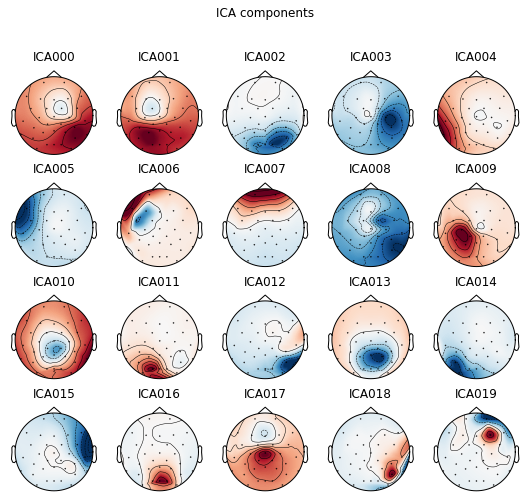

<ipython-input-23-e420c1fa1855>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-23-e420c1fa1855>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


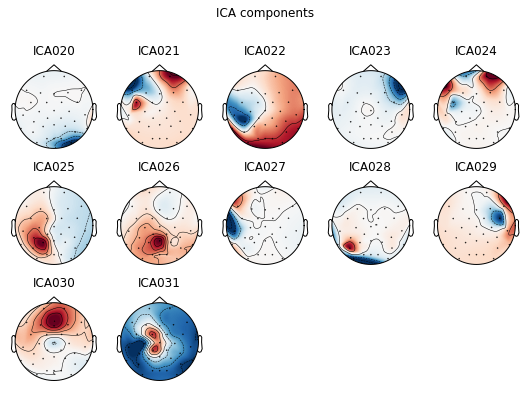

[<Figure size 540x504 with 20 Axes>, <Figure size 540x396 with 15 Axes>]

In [ ]:
data, picks = get_raw(10) #subject 10

ica = mne.preprocessing.ICA(n_components=32, random_state=0)
ica.fit(data.copy().filter(7,30))
ica.plot_components(sensors=True) 

In [ ]:
ica.exclude = [7, 23,24,19,6,21]
data10 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
datas.append(data10)

<ipython-input-24-170fe56a53cd>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data10 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-24-170fe56a53cd>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data10 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` b

Transforming to ICA space (32 components)


<ipython-input-24-170fe56a53cd>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data10 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-24-170fe56a53cd>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data10 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-24-170fe56a53cd>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data10 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-24-170fe56a53cd>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data10 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-24-170fe56a53cd>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data10 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprec

Zeroing out 6 ICA components


/usr/local/lib/python3.7/dist-packages/mne/io/meas_info.py:1903: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ch_types = np.atleast_1d(np.array(ch_types, np.str))
<ipython-input-5-a65d0e470cad>:31: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  montage=montage)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and g

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks


<ipython-input-17-955a858cb419>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-17-955a858cb419>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-17-955a858cb419>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-17-955a858cb419>:4: RuntimeWarning: the "filename" key is misleading and 

Selection by number: 32 components


<ipython-input-17-955a858cb419>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-17-955a858cb419>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-17-955a858cb419>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-17-955a858cb419>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-17-955a858cb419>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wante

Fitting ICA took 67.1s.


<ipython-input-17-955a858cb419>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-17-955a858cb419>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-17-955a858cb419>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


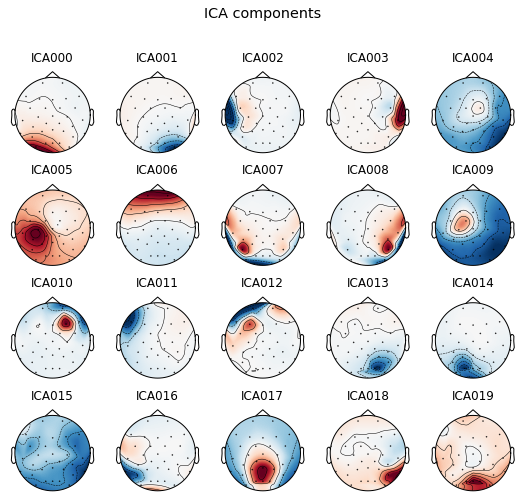

<ipython-input-17-955a858cb419>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-17-955a858cb419>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


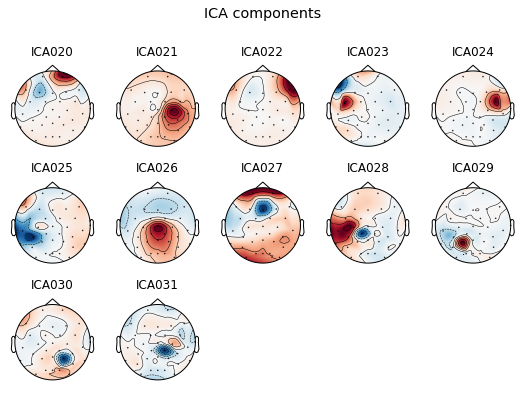

[<Figure size 540x504 with 20 Axes>, <Figure size 540x396 with 15 Axes>]

In [17]:
data, picks = get_raw(11) #subject 11

ica = mne.preprocessing.ICA(n_components=32, random_state=0)
ica.fit(data.copy().filter(7,30))
ica.plot_components(sensors=True) 

In [18]:
ica.exclude = [ 11,10,20,22, 6]
data11 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
datas.append(data11)

<ipython-input-18-558d47b6ce53>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data11 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-18-558d47b6ce53>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data11 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` b

Transforming to ICA space (32 components)
Zeroing out 5 ICA components


<ipython-input-18-558d47b6ce53>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data11 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-18-558d47b6ce53>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data11 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-18-558d47b6ce53>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data11 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-18-558d47b6ce53>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data11 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-18-558d47b6ce53>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data11 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprec

/usr/local/lib/python3.7/dist-packages/mne/io/meas_info.py:1903: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ch_types = np.atleast_1d(np.array(ch_types, np.str))
<ipython-input-4-a65d0e470cad>:31: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  montage=montage)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and g

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks


<ipython-input-27-0d2ed6ae493d>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-27-0d2ed6ae493d>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-27-0d2ed6ae493d>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-27-0d2ed6ae493d>:4: RuntimeWarning: the "filename" key is misleading and 

Selection by number: 32 components


<ipython-input-27-0d2ed6ae493d>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-27-0d2ed6ae493d>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-27-0d2ed6ae493d>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-27-0d2ed6ae493d>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-27-0d2ed6ae493d>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wante

Fitting ICA took 104.1s.


<ipython-input-27-0d2ed6ae493d>:4: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.fit(data.copy().filter(7,30))
<ipython-input-27-0d2ed6ae493d>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-27-0d2ed6ae493d>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


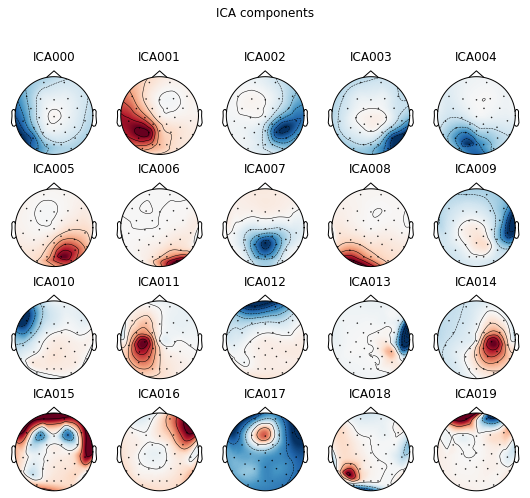

<ipython-input-27-0d2ed6ae493d>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
<ipython-input-27-0d2ed6ae493d>:5: RuntimeWarning: the "filename" key is misleading and info should not have it
  ica.plot_components(sensors=True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


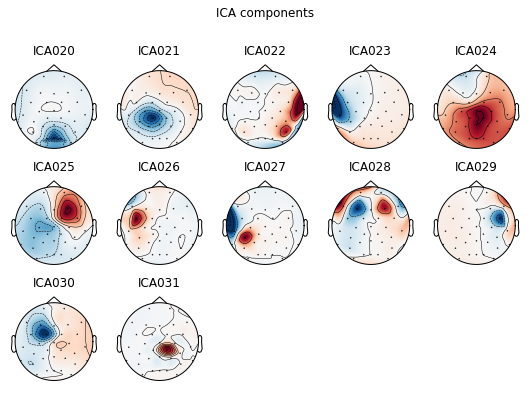

[<Figure size 540x504 with 20 Axes>, <Figure size 540x396 with 15 Axes>]

In [ ]:
data, picks = get_raw(12) #subject 12

ica = mne.preprocessing.ICA(n_components=32, random_state=0)
ica.fit(data.copy().filter(7,30))
ica.plot_components(sensors=True) 

In [ ]:
ica.exclude = [10, 12, 19]
data12 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
datas.append(data12)

<ipython-input-28-f678a11a4ef1>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data12 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-28-f678a11a4ef1>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data12 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` b

Transforming to ICA space (32 components)
Zeroing out 3 ICA components


<ipython-input-28-f678a11a4ef1>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data12 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-28-f678a11a4ef1>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data12 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-28-f678a11a4ef1>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data12 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-28-f678a11a4ef1>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data12 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
<ipython-input-28-f678a11a4ef1>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  data12 = ica.apply(data.copy().filter(7,30), exclude=ica.exclude)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprec

In [ ]:
print(datas)
subject=1#selec subsject
d = datas[subject-1] #selec subsject

[<RawArray  |  None, n_channels x n_times : 38 x 1422392 (2844.8 sec), ~412.5 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 38 x 1711494 (3423.0 sec), ~496.3 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 38 x 1335825 (2671.6 sec), ~387.4 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 38 x 1402524 (2805.0 sec), ~406.7 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 38 x 1518726 (3037.4 sec), ~440.4 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 38 x 1519417 (3038.8 sec), ~440.6 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 38 x 1652940 (3305.9 sec), ~479.3 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 38 x 1359067 (2718.1 sec), ~394.1 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 38 x 1447494 (2895.0 sec), ~419.8 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 38 x 1486915 (2973.8 sec), ~431.2 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 38 x 1

Data visualization

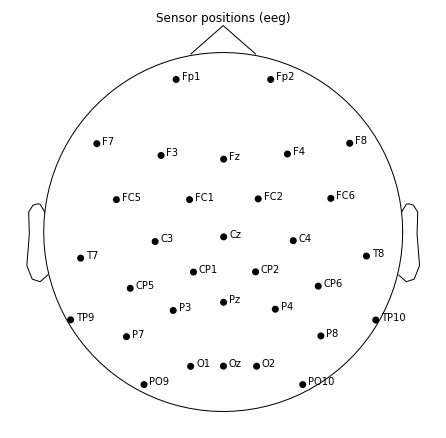

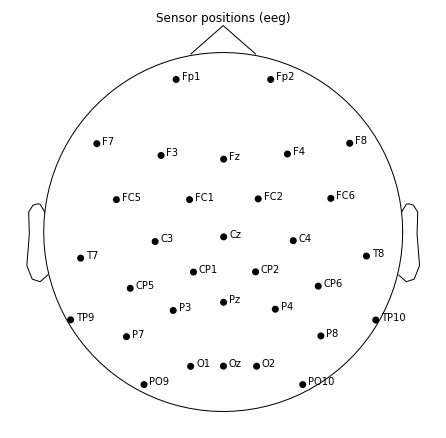

In [ ]:
d.plot_sensors(show_names='true')

<ipython-input-12-ee43e6a1bae9>:1: RuntimeWarning: the "filename" key is misleading and info should not have it
  d.plot_psd()
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
<ipython-input-12-ee43e6a1bae9>:1: RuntimeWarning: the "filename" key is misleading and info should not have it
  d.plot_psd()
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar

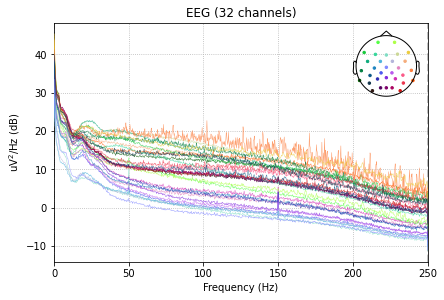

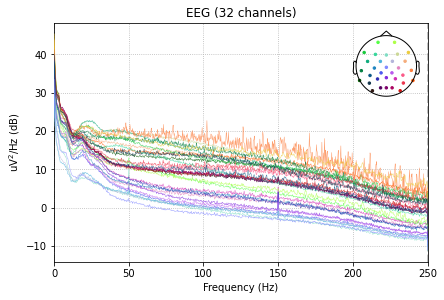

In [ ]:
d.plot_psd()

<ipython-input-13-a98c5c421a37>:2: RuntimeWarning: the "filename" key is misleading and info should not have it
  p = mne.pick_types(d.info, stim = True)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


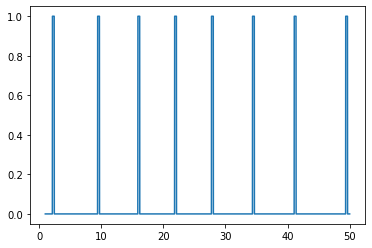

In [ ]:
#Data in the trigger channel
p = mne.pick_types(d.info, stim = True)
sfreq = d.info['sfreq']
data, time = d[p[0], int(1*sfreq): int(50*sfreq)]
plt.plot(time,data[0])

In [ ]:
# get event posision corresponding to HandStart
events = find_events(d,stim_channel='HandStart', verbose=False)

# epochs signal for 2 second after the event
epochs = Epochs(d, events, {'during' : 1}, 0, 2, proj=False,
                    picks=picks, baseline=None, preload=True,verbose=False)

/usr/local/lib/python3.7/dist-packages/mne/event.py:439: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.int)
<ipython-input-14-cbdc61629093>:6: RuntimeWarning: the "filename" key is misleading and info should not have it
  picks=picks, baseline=None, preload=True,verbose=False)
<ipython-input-14-cbdc61629093>:6: RuntimeWarning: the "filename" key is misleading and info should not have it
  picks=picks, baseline=None, preload=True,verbose=False)
<ipython-input-14-cbdc61629093>:6: RuntimeWarning: the "filename" key is misleadin

    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-17-d71b37889f3b>:1: RuntimeWarning: the "filename" key is misleading and info should not have it
  epochs.plot_psd_topomap()
<ipython-input-17-d71b37889f3b>:1: RuntimeWarning: the "filename" key is misleading and info should not have it
  epochs.plot_psd_topomap()
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)


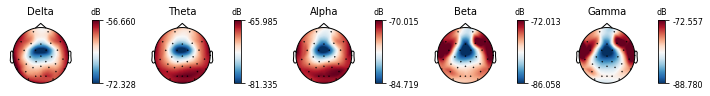

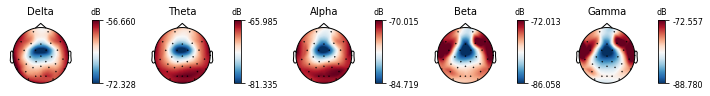

In [ ]:
epochs.plot_psd_topomap()

Data preprocessing

In [8]:
time_steps = 1000
subsample = 50

scaler = StandardScaler()

In [9]:
def get_xy(raw):
    X = raw._data[picks].T
    y = raw._data[32:].T
    return X,y

def filter_dataset(x_dataset, y_dataset):
    x_data_filter = []
    y_data_filter = []
    for i in range(x_dataset.shape[0]-time_steps):
        if 1 in y_dataset[i+time_steps]:
            x_data_filter.append(x_dataset[i:i+time_steps:subsample])
            y_data_filter.append(y_dataset[i+time_steps])
    x_data_filter = np.array(x_data_filter)
    y_data_filter = np.array(y_data_filter)
    return x_data_filter, y_data_filter

Our CNN model

In [10]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Input,Dense,Conv2D,ReLU,ELU,\
  Activation,Flatten,AveragePooling2D,Softmax,BatchNormalization,MaxPooling2D,\
  Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,\
  ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from datetime import datetime

Here is example of training 9 and 11 subjects, because we did training on diffetent jupyter notebooks

In [26]:
subject = (data9)

print("-------------------------------")
X, y = get_xy(subject)
print("X & y shape")
print(X.shape,y.shape)

X = scaler.fit_transform(X)

print("-------------------------------")
Xf, yf = filter_dataset(X, y)
print("Xf & yf shape")
print(Xf.shape,yf.shape)

Xf, yf = utils.shuffle(Xf, yf)
from sklearn.model_selection import train_test_split
X_f,X_test,y_f,y_test=train_test_split(Xf,yf,test_size=0.2,random_state=1234,stratify=yf)

def create_model(X_data):
    model = Sequential()
    model.add(Conv2D(filters = 32, padding = "same", kernel_size = (X_data.shape[1],3), activation=tf.keras.layers.LeakyReLU(alpha=0.3), input_shape = (X_data.shape[1], X_data.shape[2], 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 64, padding = "same", kernel_size = (X_data.shape[2],1), activation=tf.keras.layers.LeakyReLU(alpha=0.3)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation = tf.keras.layers.LeakyReLU(alpha=0.3)))
    model.add(BatchNormalization())
    model.add(Dense(64, activation = tf.keras.layers.LeakyReLU(alpha=0.3)))
    model.add(BatchNormalization())
    model.add(Dense(6, activation = "sigmoid"))

    adam = keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])
    
    return model

print("-------------------------------")
model = create_model(Xf)
from keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=2)
model.fit(Xf, yf, epochs=10, batch_size=256, validation_split=0.3,callbacks=[es])
print("-------------------------------------------------------------------------------------------------")

-------------------------------
X & y shape
(1447494, 32) (1447494, 6)
-------------------------------
Xf & yf shape
(193344, 20, 32) (193344, 6)
-------------------------------


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
529/529 [==============================] - 24s 44ms/step - loss: 0.5102 - accuracy: 0.3002 - val_loss: 0.4446 - val_accuracy: 0.3896
Epoch 2/10
529/529 [==============================] - 23s 43ms/step - loss: 0.3272 - accuracy: 0.5772 - val_loss: 0.2460 - val_accuracy: 0.6811
Epoch 3/10
529/529 [==============================] - 23s 44ms/step - loss: 0.1487 - accuracy: 0.7985 - val_loss: 0.1167 - val_accuracy: 0.8303
Epoch 4/10
529/529 [==============================] - 23s 44ms/step - loss: 0.0637 - accuracy: 0.8731 - val_loss: 0.0703 - val_accuracy: 0.8641
Epoch 5/10
529/529 [==============================] - 24s 45ms/step - loss: 0.0351 - accuracy: 0.8899 - val_loss: 0.0577 - val_accuracy: 0.8701
Epoch 6/10
529/529 [==============================] - 25s 46ms/step - loss: 0.0295 - accuracy: 0.8897 - val_loss: 0.0535 - val_accuracy: 0.8701
Epoch 7/10
529/529 [==============================] - 25s 46ms/step - loss: 0.0226 - accuracy: 0.8921 - val_loss: 0.0510 - val_accuracy:

In [21]:
subject = (data11)

print("-------------------------------")
X, y = get_xy(subject)
print("X & y shape")
print(X.shape,y.shape)

X = scaler.fit_transform(X)

print("-------------------------------")
Xf, yf = filter_dataset(X, y)
print("Xf & yf shape")
print(Xf.shape,yf.shape)

Xf, yf = utils.shuffle(Xf, yf)
from sklearn.model_selection import train_test_split
X_f,X_test,y_f,y_test=train_test_split(Xf,yf,test_size=0.2,random_state=1234,stratify=yf)

def create_model(X_data):
    model = Sequential()
    model.add(Conv2D(filters = 32, padding = "same", kernel_size = (X_data.shape[1],3), activation=tf.keras.layers.LeakyReLU(alpha=0.3), input_shape = (X_data.shape[1], X_data.shape[2], 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 64, padding = "same", kernel_size = (X_data.shape[2],1), activation=tf.keras.layers.LeakyReLU(alpha=0.3)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation = tf.keras.layers.LeakyReLU(alpha=0.3)))
    model.add(BatchNormalization())
    model.add(Dense(64, activation = tf.keras.layers.LeakyReLU(alpha=0.3)))
    model.add(BatchNormalization())
    model.add(Dense(6, activation = "sigmoid"))

    adam = keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])
    
    return model

print("-------------------------------")
model = create_model(Xf)
from keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=2)
model.fit(Xf, yf, epochs=10, batch_size=256, validation_split=0.3,callbacks=[es])
print("-------------------------------------------------------------------------------------------------")

-------------------------------
X & y shape
(1521037, 32) (1521037, 6)
-------------------------------
Xf & yf shape
(201182, 20, 32) (201182, 6)
-------------------------------


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
551/551 [==============================] - 25s 44ms/step - loss: 0.4839 - accuracy: 0.3286 - val_loss: 0.3943 - val_accuracy: 0.4746
Epoch 2/10
551/551 [==============================] - 23s 43ms/step - loss: 0.2756 - accuracy: 0.6526 - val_loss: 0.1929 - val_accuracy: 0.7525
Epoch 3/10
551/551 [==============================] - 24s 43ms/step - loss: 0.1162 - accuracy: 0.8476 - val_loss: 0.1042 - val_accuracy: 0.8488
Epoch 4/10
551/551 [==============================] - 24s 44ms/step - loss: 0.0515 - accuracy: 0.9015 - val_loss: 0.0626 - val_accuracy: 0.8902
Epoch 5/10
551/551 [==============================] - 24s 44ms/step - loss: 0.0304 - accuracy: 0.9141 - val_loss: 0.0576 - val_accuracy: 0.8970
Epoch 6/10
551/551 [==============================] - 24s 44ms/step - loss: 0.0259 - accuracy: 0.9133 - val_loss: 0.0384 - val_accuracy: 0.8993
Epoch 7/10
551/551 [==============================] - 25s 45ms/step - loss: 0.0203 - accuracy: 0.9169 - val_loss: 0.0456 - val_accuracy:

In [22]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=256)#for 11 subject
print('Test score:', score)
print('Test accuracy:', acc)

158/158 [==============================] - 2s 11ms/step - loss: 0.0116 - accuracy: 0.9242
Test score: 0.011563594453036785
Test accuracy: 0.9242488145828247


In [27]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=256)#for 9 subject
print('Test score:', score)
print('Test accuracy:', acc)

152/152 [==============================] - 2s 12ms/step - loss: 0.0321 - accuracy: 0.8824
Test score: 0.03208521008491516
Test accuracy: 0.8824122548103333
